In [2]:
import os
from pathlib import Path
from glob import glob
import scipy.io
import mne

IDD = Path('EEG dataset/Data/CleanData/CLeanData_IDD/Rest')
TDC = Path('EEG dataset/Data/CleanData/CLeanData_TDC/Rest')

In [3]:
# Load the file using scipy
import matplotlib.pyplot as plt

# Fix the path typo (CLeanData -> CleanData)
IDD_NDS001_Rest = Path('EEG dataset/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD.mat')
print(f"Loading: {IDD_NDS001_Rest}")

# Load the data
data_dict = scipy.io.loadmat(str(IDD_NDS001_Rest))
print(f"Keys in file: {list(data_dict.keys())}")

# Extract the clean data
clean_data = data_dict['clean_data']
print(f"Data shape: {clean_data.shape}")
print(f"Data type: {clean_data.dtype}")
print(f"Data min: {clean_data.min()}, max: {clean_data.max()}")


Loading: EEG dataset\Data\CleanData\CleanData_IDD\Rest\NDS001_Rest_CD.mat
Keys in file: ['__header__', '__version__', '__globals__', 'clean_data']
Data shape: (14, 15360)
Data type: float32
Data min: -166.75436401367188, max: 188.61766052246094


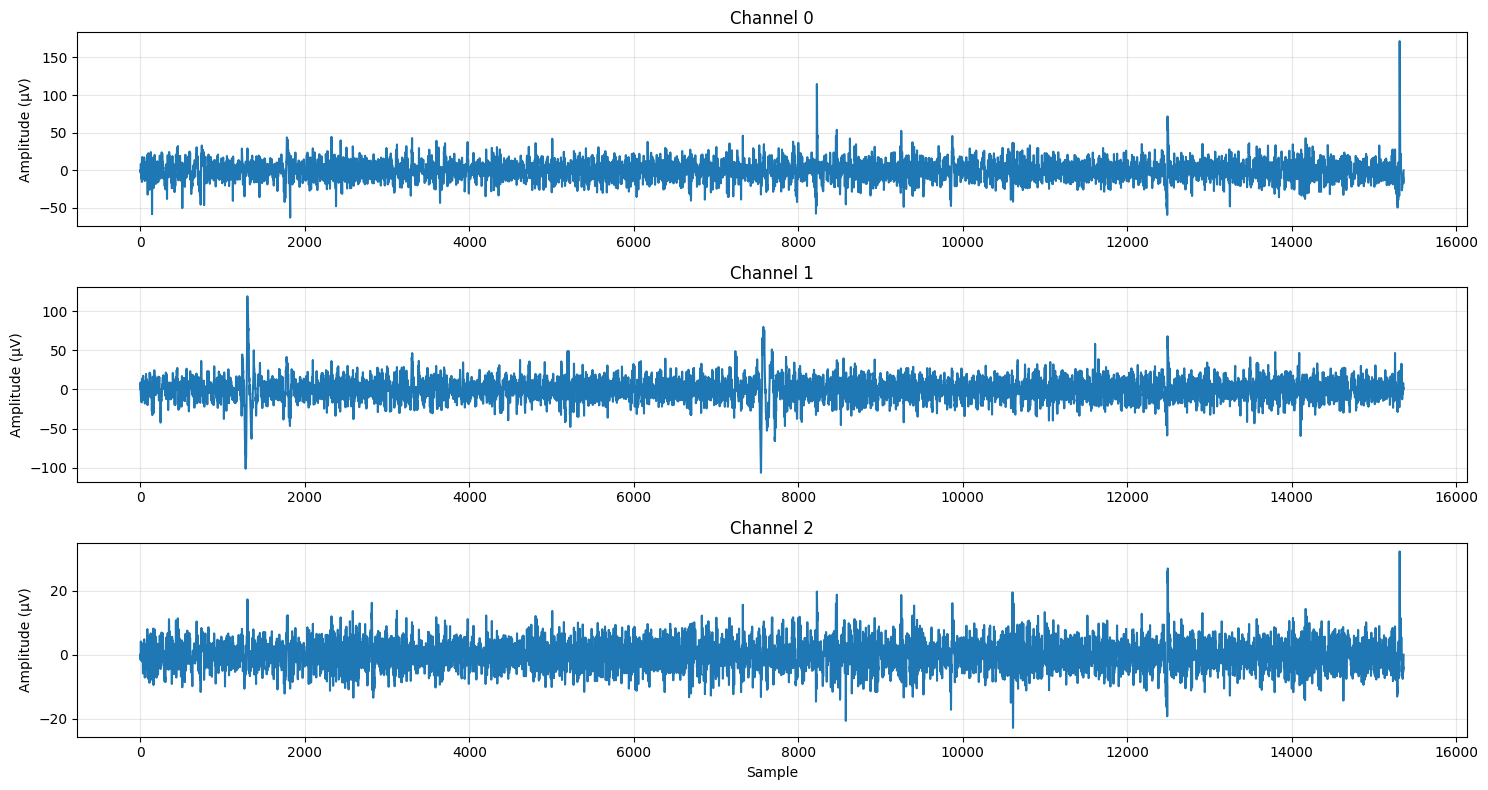

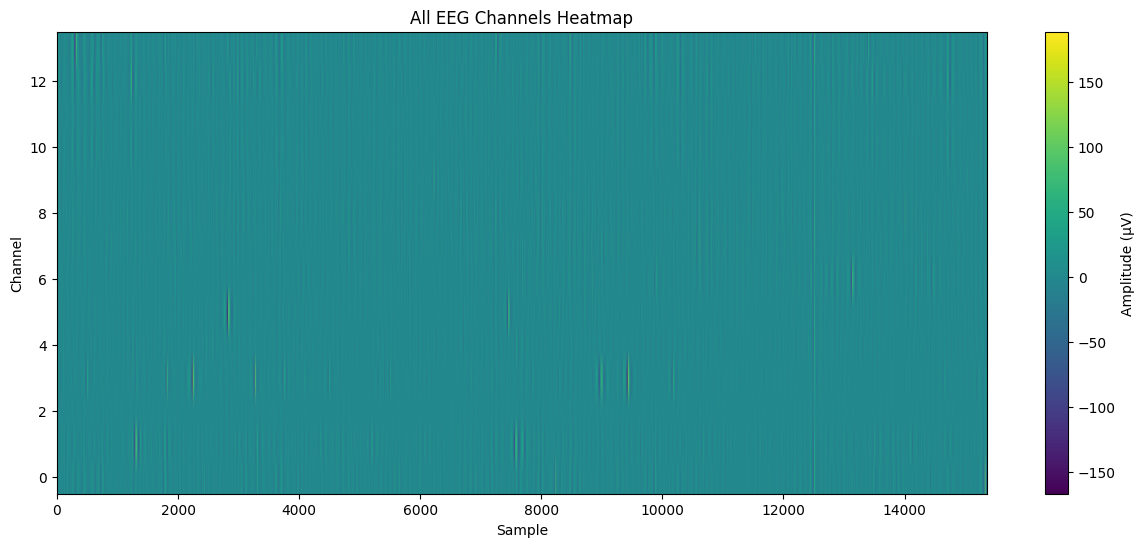

In [4]:
# Visualize the data
plt.figure(figsize=(15, 8))

# Plot first 3 channels for visualization
for ch in range(min(3, clean_data.shape[0])):
    plt.subplot(3, 1, ch + 1)
    time_samples = clean_data.shape[1]
    time_seconds = time_samples / 128  # sampling rate is 128 Hz
    plt.plot(clean_data[ch, :])
    plt.title(f'Channel {ch}')
    plt.ylabel('Amplitude (μV)')
    if ch == 2:
        plt.xlabel('Sample')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Also create a heatmap of all channels
plt.figure(figsize=(15, 6))
plt.imshow(clean_data, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude (μV)')
plt.title('All EEG Channels Heatmap')
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.show()


In [23]:
# Use os.path.join for proper path construction
pattern = os.path.join(IDD, '*.mat')
idd_files = glob(pattern)

for idd in idd_files:
    data = scipy.io.loadmat(idd)
    break

In [24]:
keys = list(data.keys())
print(keys)

data = data[keys[3]]
data.shape

['__header__', '__version__', '__globals__', 'clean_data']


['__header__', '__version__', '__globals__', 'clean_data']


(14, 15360)

In [25]:
import mne

n_channels = 14
sampling_freq = 128  #in hertz
info = mne.create_info(n_channels, sfreq = sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
 chs: 14 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>


In [28]:
data = mne.io.RawArray(data,info)

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.


In [29]:
epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [30]:
epochs.get_data().shape

Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


(30, 14, 512)

In [40]:
def convertMatToMNE(data):
    ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    ch_types = ['eeg'] * 14
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage('standard_1020')
    
    data = mne.io.RawArray(data,info)
    # data.set_egg_reference()
    data.filter(l_freq=1, h_freq=30)
    epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)
    return epochs.get_data()


In [47]:
%%capture

pattern = os.path.join(IDD, '*.mat')
idd_files = glob(pattern)
idd_subject = []

for idd in idd_files:
    data = scipy.io.loadmat(idd)['clean_data']
    data = convertMatToMNE(data)
    idd_subject.append(data)

In [48]:
%%capture

pattern = os.path.join(TDC, '*.mat')
tdc_files = glob(pattern)
tdc_subject = []

for tdc in tdc_files:
    data = scipy.io.loadmat(tdc)['clean_data']
    data = convertMatToMNE(data)
    tdc_subject.append(data)


In [46]:
len(idd_subject), len(tdc_subject)

(7, 7)

In [51]:
healthy_epoch_labels = [len(i) *[0] for i in tdc_subject]
patient_epoch_labels = [len(i) *[1] for i in idd_subject]    
len(healthy_epoch_labels), len(patient_epoch_labels)

(7, 7)

In [52]:
data_list = tdc_subject + idd_subject
labels_list = healthy_epoch_labels + patient_epoch_labels 
len(data_list), len(labels_list)  

(14, 14)

In [53]:
groups_list = [[i]*len(j) for i,j in enumerate(data_list)]

In [58]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
import numpy as np

gkf = GroupKFold()

data_array = np.vstack(data_list)
labels_array = np.hstack(labels_list)
group_array = np.hstack(groups_list)


In [60]:
accuracy = []
for train_index, val_index in gkf.split(data_array, labels_array, groups=group_array):
    train_features, train_labels=data_array[train_index], labels_array[train_index]
    val_features, val_labels = data_array[val_index], labels_array[val_index]
    scaler = StandardScaler()

    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    break

In [61]:
train_features.shape

(330, 14, 512)